# My first project with Convolutional Neural Network

## In this notebook, I will create a Convolutional Neural Network(CNN) using Tensorflow on a set of medical images. Using data augmentation techniques, the CNN is able to achieve an accuracy score of 80% on a small set of images. Below are the details of the steps I take to finish this project. 

### Import and Export images

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
from numpy import *

import os

### set path to retrieve and copy images into
path1 = r'C:\Users\tnguy\Downloads\TE_image_case'
path2 = r'C:\Users\tnguy\Downloads\TE_images_resized1'

### Retrive he set of images from path 1 and copy them into path2
listing = os.listdir(path1)
num_samples = size(listing)
print(num_samples)
img_rows, img_cols = 28, 28
for file in listing:
    im = Image.open(path1+'\\'+file)
    img = im.resize((img_rows, img_cols))
    gray = img.convert('L')
    gray.save(path2 +'\\' + file, 'JPEG')



C:\Users\tnguy\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


171


### Loading images

In [2]:
### Load the images into list1
img_rows, img_cols = 224, 224
imlist = os.listdir(path2)

im1 = array(Image.open(path2 + '\\' + imlist[0]))
m,n = im1.shape[0:2]
imnbr = len(imlist)    

immatrix = array([array(Image.open(path2 + '\\' + im2)).flatten() for im2 in imlist], 'f')
list1 = []
for i in range(len(immatrix)):
    list1.append(immatrix[i])
list1 = np.array(list1)

171


### Labeling and Plotting the images

(171, 50176)
(171,)


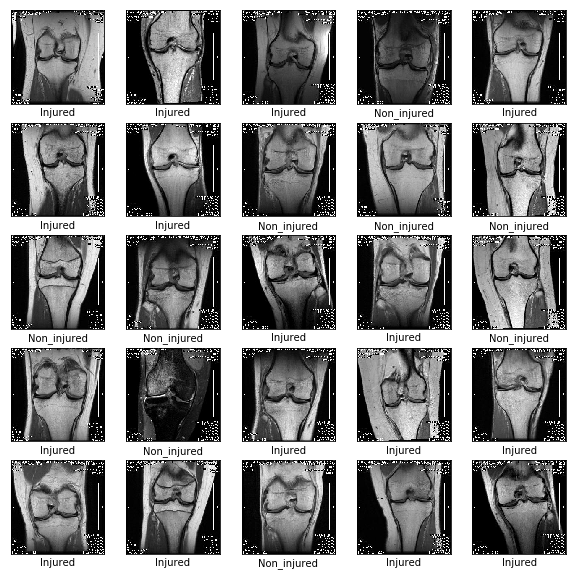

In [108]:
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier
label = np.ones((num_samples,) ,dtype = int)
# There are 69 non-injjured images and 102 injured images
label[0:69] = 0
label[69:] = 1

data, label = shuffle(immatrix, label, random_state=2)
train_data = [data,label]
train_1 = (train_data[1]==1)
plt.figure(figsize=(10,10))
class_names = ['Non_injured', 'Injured']
### Plot the first 25 images in the dataset
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[0][i].reshape(224,224), cmap = 'gray')
    plt.xlabel(class_names[Y_train_r[i]])
print(train_data[0].shape)
print(train_data[1].shape)

In [47]:
type(train_data[0])

numpy.ndarray

### Data Augmentation

As shown above, we only have a set of 171 images which is pretty small. One solution to this problem is to augment the dataset. Some common data augmentation techniques are cropping, adding noise to, flipping the images, etc... We'll be adding noise and cropping our images in this notebook.

(171, 50176)


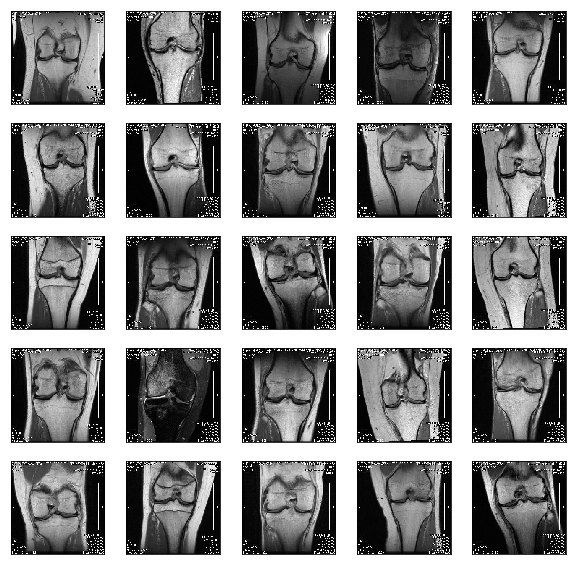

In [103]:
### Add noise to the images
shape = [None,224*224*1]
def add_noise(imgs, shape):
    gauss = tf.placeholder(dtype = tf.float32, shape=shape)
    noise = tf.random_normal(shape=tf.shape(gauss), mean=0.0, stddev=1.0,
    dtype=tf.float32)
    output = tf.add(gauss, noise)
    init = tf.global_variables_initializer()
    gaussian_noise = []
    with tf.Session() as sess:
        init.run()
        gaussian = (sess.run(output, feed_dict={gauss:imgs[0]}))
    return gaussian

gaussian = add_noise(train_data, shape)
print(gaussian.shape)
### Showing the first 25 images after adding noise to the dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gaussian[i].reshape(224,224), cmap = 'gray')


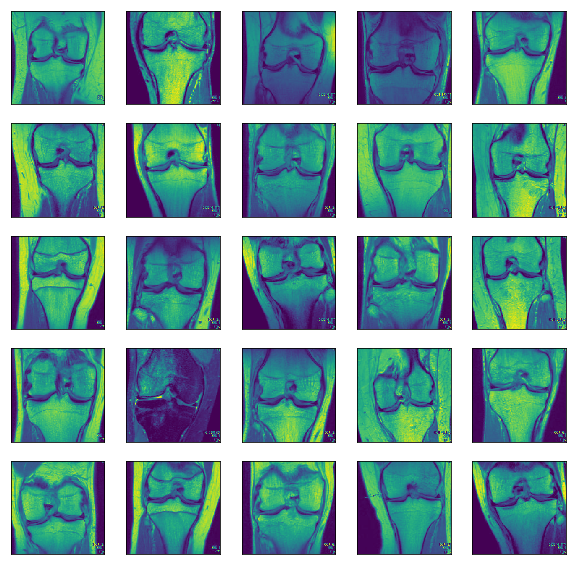

In [101]:
### Cropping the images by a factor of 0.75
IMAGE_SIZE = 224
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 1))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data
scaled_imgs = central_scale_images(train_data[0].reshape(-1,224,224,1), [0.75])
### showing the first 25 cropped images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(scaled_imgs[i].reshape(224,224))

### Labeling the augmented images

In [13]:
def fill_label(array, label):
    list1 = []
    list1.append(array)
    list1.append(label)
    return list1

scale_imgs_label = fill_label(scaled_imgs, train_data[1])
gaussian_noise = fill_label(gaussian, train_data[1])

In [51]:
### Adding the augmented images back into the dataset
train_dataset = []
train_dataset.append(train_data[0].tolist()+scale_imgs_label[0].reshape(-1,224*224).tolist()+gaussian_noise[0].tolist())
train_dataset.append(train_data[1].tolist()+scale_imgs_label[1].tolist()+gaussian_noise[1].tolist())
print(np.array(train_dataset[0]).shape)

(513, 50176)


### Splitting train, validation and test sets

In order to ensure that our trainning set will not exclusively contain one of the two labelled images(namely, only injured or only non-injured), we use StratifiedShuffle from scikit-learn to ensure the ratio of the two labels are the same in both the train, test and validation sets. 

length of train_index: 410 length of test_index: 103
length of train_index: 410 length of test_index: 103
TRAIN: 328 TEST: 82
TRAIN: 328 TEST: 82
X_train shape: (328, 50176)
410 train_samples
103 test_samples
82 val_samples
Y_train.shape: (328,)
1


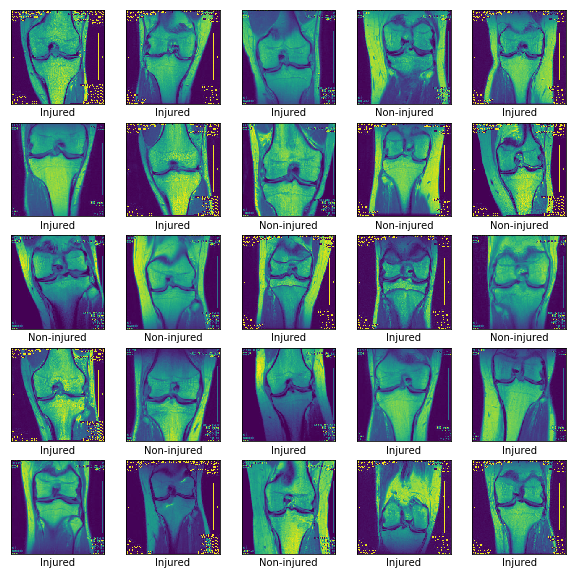

In [93]:
### Using StratifiedShuffle from scikit-learn to split the dataset proportionate to its injured to non-injured ratio.
### The dataset will be split in a 80:20 ratio. The training and test set will each contain the same ratio of injured to non-injured.
from sklearn.model_selection import StratifiedShuffleSplit

### Split the training and label sets from train_dataset
(X,y) = (np.array(train_dataset[0]), np.array(train_dataset[1]))

### using Stratified ShuffleSplit to split the dataset
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=4)
for train_index, test_index in sss.split(X,y):
    print('length of train_index:', len(train_index), 'length of test_index:', len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Doing the same thing when splitting train and validation set
sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=4)

for train_index1, test_index1 in sss1.split(X_train,y_train):
    print("TRAIN:", len(train_index1), "TEST:", len(test_index1)) 
   # print('length of train_index:', len(train_index), 'length of val_index:', len(test_index))
    X_train_r, X_val = X_train[train_index1], X_train[test_index1]
    y_train_r, y_val = y_train[train_index1], y_train[test_index1]

### reshaping the datasets into the dimensions that the model accepts
X_train_r = X_train_r.reshape(X_train_r.shape[0], img_rows* img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows* img_cols)
X_val = X_val.reshape(X_val.shape[0], img_rows* img_cols)

### setting the value to floats
X_train_r = X_train_r.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

### speeding up the trainning process by dividing the dataset by 225, which is the number of pixels
X_train_r /= 225
X_test /= 225
X_val /=225

### print out the shape of the train, validation, and test sets
print('X_train shape:', X_train_r.shape)
print(X_train.shape[0], 'train_samples')
print(X_test.shape[0], 'test_samples')
print(X_val.shape[0], 'val_samples')

Y_train_r = y_train_r.astype(np.int32)
Y_test = y_test.astype(np.int32)
Y_val = y_val.astype(np.int32)
#Y_train_r = np_utils.to_categorical(y_train_r, 2)
#Y_test = np_utils.to_categorical(y_test, 2)
#Y_val = np_utils.to_categorical(y_val, 2)
print('Y_train.shape:', Y_train_r.shape)
print(Y_train_r[0])

### Print out the first 25 images in the training set
plt.figure(figsize = (10,10))
class_names = ['Non-injured', 'Injured']
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_r[i].reshape(224,224))
    plt.xlabel(class_names[Y_train_r[i]])

#### Now I can start building my CNN for the dataset. 


In [94]:
# This CNN will contain two convolutional layers, one max pool later and one fully connected layer. 
height = 224
width = 224
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.5

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 2

tf.reset_default_graph()
# let's first create placeholders, so that we can later feed our data in, for X, Y which are the variables that hold our 
# training data. X will have shape of [n_examples, height, width, channels]. In the code we see that 
# X initially has a shape of [None, n_inputs] then is reshaped to be [-1, height, width, channels]. As we defined above, 
# height = width = 224 while channels =1 . The numnber -1 basically tells the system to figure it out on its own that 
# unknown dimension based on the dataset. Here it will be the number of training inputs. Lastly, tf.place_holder_with_default
# will feed X, Y with 0's before the training inputs are fed so that we can run our graph.
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
# There are two convolutional layers in our CNN. the first one has 32 feature maps, with each map of shape 3x3. We
# will padd the image first before convolute the image with a stride of 1x1. The second convolutional layer has pretty much
# the same feature as those of the first one except for the number of feature maps which is 64. 
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
# Once the CNN finishes convoluting the images, it will then trim the numberr of parameters to be calculated 
# by max_pooling the images. In this layer, there are 
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 56 * 56])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [98]:
### This function will return the mini_batches
def get_batch(X, y, batch_size):
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(range(len(X)), n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch


### Early Stopping
early stopping is a technique aimed to reduce trainning time by saving the best trained model and stops trainning after a specified number of steps.

In [96]:
### This function will save the parameters of a trained model
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

### this functions will retrieve the parameters of a specified trained model
def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

### Training and Evaluating

In [99]:
### Initialize the numberr of trainning steps, batch size and others. 
n_epochs = 100
batch_size = 3
iteration = 0

best_loss_val = np.infty
check_interval = 25
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        ### feed the mini batches to the model
        for X_batch, y_batch in get_batch(X_train_r, Y_train_r, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            ### Evaluate the result after a number of steps
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_val,
                                                y: y_val})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val,
                                           y: y_val})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        ### If the model doesn't improve after a specified number of steps, early stopping!
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break
### save the model and evaluate it on the test set
    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: X_test, 
                                        y: y_test})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

Epoch 0, train accuracy: 66.6667%, valid. accuracy: 74.3902%, valid. best loss: 0.505805
Epoch 1, train accuracy: 100.0000%, valid. accuracy: 75.6098%, valid. best loss: 0.441178
Epoch 2, train accuracy: 100.0000%, valid. accuracy: 75.6098%, valid. best loss: 0.441178
Epoch 3, train accuracy: 100.0000%, valid. accuracy: 76.8293%, valid. best loss: 0.441178
Epoch 4, train accuracy: 100.0000%, valid. accuracy: 76.8293%, valid. best loss: 0.441178
Epoch 5, train accuracy: 100.0000%, valid. accuracy: 76.8293%, valid. best loss: 0.441178
Epoch 6, train accuracy: 100.0000%, valid. accuracy: 78.0488%, valid. best loss: 0.441178
Early stopping!
Final accuracy on test set: 0.80582523


### Conclusion

We are able to create a CNN that achieves an accuracy score of around 80% using data augmentation technique. Another way to improve the performance of the model is to tune in the hyperparameters of the model. That would be our next step.